In [14]:
import torch
from Models import modelpool
from Preprocess import datapool
from torch import nn
from spiking_layer_ours import SPIKE_layer
import numpy as np
from copy import deepcopy
from utils_my import add_dimension
from utils_my import replace_maxpool2d_by_avgpool2d, replace_layer_by_tdlayer
from slerp import slerp
from collections import OrderedDict
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

class CIFAR10WDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        super().__init__()
        dataset = torch.load(data_path, weights_only=True)
        self.data = dataset['data']
        self.labels = dataset['labels']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        return img, label


def isActivation(name):
    if 'relu' in name.lower():
        return True
    return False

def replace_activation_by_spike(model, thresholds, thresholds1, n_steps, counter=0):
    thresholds_new = deepcopy(thresholds)
    thresholds_new1 = deepcopy(thresholds1)
    
    for name, module in model._modules.items():
        if hasattr(module,"_modules"):
            model._modules[name], counter, thresholds_new = replace_activation_by_spike(module, thresholds_new, thresholds_new1, n_steps, counter)
        if isActivation(module.__class__.__name__.lower()):
            thresholds_new[counter, n_steps:] = thresholds_new1[counter, 1] / n_steps  # thresholds_out_sum/n_steps# thresholds1[counter,1] / n_steps
            thresholds_new[counter, :n_steps] = thresholds_new1[counter, 0] / n_steps  # thresholds_inner_sum/n_steps#thresholds1[counter,0] / n_steps
            model._modules[name] = SPIKE_layer(thresholds_new[counter, n_steps:], thresholds_new[counter, 0:n_steps])
            counter += 1
    return model, counter, thresholds_new


def interpolate_state_dicts(state_dict_1, state_dict_2, weight,
                            bias_norm=False, use_slerp=False):
    if use_slerp:
        model_state = deepcopy(state_dict_1)
        for p_name in model_state:
            if "batches" not in p_name:
                model_state[p_name] = slerp(weight, state_dict_1[p_name], state_dict_2[p_name])
        return model_state
    elif bias_norm:
        model_state = deepcopy(state_dict_1)
        height = 0
        for p_name in model_state:
            if "batches" not in p_name:
                model_state[p_name].zero_()
                if "weight" in p_name:
                    model_state[p_name].add_(1.0 - weight, state_dict_1[p_name])
                    model_state[p_name].add_(weight, state_dict_2[p_name])
                    height += 1
                if "bias" in p_name:
                    model_state[p_name].add_((1.0 - weight)**height, state_dict_1[p_name])
                    model_state[p_name].add_(weight**height, state_dict_2[p_name])
                if "res_scale" in p_name:
                    model_state[p_name].add_(1.0 - weight, state_dict_1[p_name])
                    model_state[p_name].add_(weight, state_dict_2[p_name])
        return model_state
    else:
        return {key: (1 - weight) * state_dict_1[key] + 
                weight * state_dict_2[key] for key in state_dict_1.keys()}
        

def interpolate_multi_state_dicts(sd_s, weight_s, use_slerp=False):
    if use_slerp:
        sd_interpolated = deepcopy(sd_s[0])
        weight_interpolated = weight_s[0]
        for i in range(1, len(sd_s)):
            sd_next = sd_s[i]
            weight_next = weight_s[i]
            t = weight_next / (weight_interpolated + weight_next)
            sd_interpolated = interpolate_state_dicts(sd_interpolated, sd_next, t, use_slerp=use_slerp)
            weight_interpolated += weight_next
        return sd_interpolated
    else:
        sd_interpolated = deepcopy(sd_s[0])
        for key in sd_s[0].keys():
            sd_interpolated[key] = weight_s[0] * sd_s[0][key]
            for i in range(1, len(sd_s)):
                sd_interpolated[key] += weight_s[i] * sd_s[i][key]
        return sd_interpolated
    

def validate_snn(model, loader, n_steps, device, verbose=1, use_double=False):
    device_old = get_device(model)
    model.to(device)
    model.eval()
    total = 0
    correct = 0
    for data, target in loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        if use_double:
            data = data.double()
        output = model(data, L=0, t=n_steps)
        output = torch.mean(output, dim=1)
        total += target.size(0)
        correct += (output.argmax(1) == target).sum().item()
    if verbose != 0:
        print('Accuracy of the network on the test images: %f' % (100 * correct / total))
    acc = 100 * correct / total
    model.to(device_old)
    return acc

def validate_snn_ensemble(models, loader, n_steps, device, verbose=1):
    device_old = get_device(models[0])
    for model in models:
        model.to(device)
        model.eval()
    total = 0
    correct = 0
    for data, target in loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        output = torch.zeros(data.size(0), 10).to(device)
        for model in models:
            output += torch.mean(model(data, L=0, t=n_steps), dim=1)
        total += target.size(0)
        correct += (output.argmax(1) == target).sum().item()
    if verbose != 0:
        print('Accuracy of the network on the test images: %f' % (100 * correct / total))
    acc = 100 * correct / total
    for model in models:
        model.to(device_old)
    return acc
    
def validate_ann(model, loader, device, verbose=1, use_double=False):
    device_old = get_device(model)
    model.to(device)
    model.eval()
    total = 0
    correct = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        if use_double:
            data = data.double()
        output = model(data)
        total += target.size(0)
        correct += (output.argmax(1) == target).sum().item()
    if verbose != 0:
        print('Accuracy of the network on the test images: %f' % (100 * correct / total))
    acc = 100 * correct / total
    model.to(device_old)
    return acc


def ann_to_snn(model, thresholds, thresholds1, n_steps):
    model, counter, thresholds_new = replace_activation_by_spike(model, thresholds, thresholds1, n_steps)
    model = replace_maxpool2d_by_avgpool2d(model)
    model = replace_layer_by_tdlayer(model)
    return model, thresholds_new

def snn_to_ann(model, use_maxpooling=True):
    new_model = deepcopy(model)
    for name, module in new_model._modules.items():
        if hasattr(module, "_modules"):
            new_model._modules[name] = snn_to_ann(module)
        if module.__class__.__name__ == 'SPIKE_layer':
            new_model._modules[name] = nn.ReLU()
        elif module.__class__.__name__ == 'tdLayer':
            if use_maxpooling and isinstance(module.layer.module, nn.AvgPool2d):
                module.layer.module = nn.MaxPool2d(kernel_size=module.layer.module.kernel_size,
                                                stride=module.layer.module.stride,
                                                padding=module.layer.module.padding)
            new_model._modules[name] = module.layer.module
        elif module.__class__.__name__ == 'Flatten':
            new_model._modules[name] = nn.Flatten()
    return new_model

def tranfer_bn_stats_from_ann_to_snn(ann_model, snn_model):
    new_snn_model = deepcopy(snn_model)
    ann_bn_layer_names = [name for name, layer in ann_model.named_modules() if isinstance(layer, (nn.BatchNorm2d))]
    snn_bn_layer_names = [name for name, layer in new_snn_model.named_modules() if isinstance(layer, (nn.BatchNorm2d))]
    for ann_bn_name, snn_bn_name in zip(ann_bn_layer_names, snn_bn_layer_names):
        ann_bn_layer = dict(ann_model.named_modules())[ann_bn_name]
        snn_bn_layer = dict(new_snn_model.named_modules())[snn_bn_name]
        snn_bn_layer.running_mean = ann_bn_layer.running_mean
        snn_bn_layer.running_var = ann_bn_layer.running_var
        snn_bn_layer.num_batches_tracked = ann_bn_layer.num_batches_tracked
    return new_snn_model


def bn_calibration_init(m):
    """ calculating post-statistics of batch normalization """
    if getattr(m, 'track_running_stats', False):
        # reset all values for post-statistics
        m.reset_running_stats()
        # set bn in training mode to update post-statistics
        m.training = True
        # use cumulative moving average
        m.momentum = None

def reset_bn_stats(model, device, bn_loader, n_steps, layerwise=False, ann=False, use_double=False):
    # Reset batch norm statistics
    model.to(device)
    # get batchnorm layer names
    bn_layer_names = [name for name, layer in model.named_modules() if isinstance(layer, (nn.BatchNorm2d))]
    for m in model.modules():
        bn_calibration_init(m)
    model.train()
    with torch.no_grad():
        L_range = range(1, 14) if layerwise else [0]
        for L in L_range:
            for data, _ in bn_loader:
                if not ann:
                    data = add_dimension(data, n_steps)
                data = data.to(device)
                if use_double:
                    data = data.double()
                model(data, L=L, t=n_steps)
            # set current bn layer in eval mode
            if layerwise:
                layer = dict(model.named_modules())[bn_layer_names[L-1]]
                layer.eval()
    model.eval()
    model.to('cpu')

def get_device(item):
    if isinstance(item, nn.Module):
        return next(item.parameters()).device
    elif isinstance(item, OrderedDict):
        return next(iter(item.values())).device

In [15]:
class args:
    model = 'vgg16'
    dataset = 'cifar10'
    batch_size = 128
    t = 1
device = torch.device('cuda:1')
criterion = nn.CrossEntropyLoss()
n_steps = args.t
train_loader, test_loader = datapool(args.dataset, args.batch_size, 0, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# v_idx_s = list(range(2, 16)) + list(range(22, 37))
v_idx_s = list(range(2, 13))
# v_idx_s = [2]
num_models = len(v_idx_s) + 1

In [17]:
model_s = [modelpool(args.model, args.dataset) for _ in range(num_models)]
ckpt_model_idx = 3
sd = torch.load(f'saved_models/cifar10_vgg16_{ckpt_model_idx}.pth', map_location='cpu', weights_only=True)
for model in model_s:
    model.load_state_dict(sd)

num_relu = str(model_s[0]).count('ReLU')
# prefix = 'cifar10_vgg16_3_lr_1e3/'
prefix = ''
thresholds = torch.zeros(num_relu, 2*n_steps)
thresholds1 = torch.Tensor(np.load(f'{prefix}cifar10_vgg16_{ckpt_model_idx}_threshold_all_noaug{n_steps}.npy'))

In [18]:
validate_ann(model_s[0], test_loader, device)

Accuracy of the network on the test images: 95.880000


95.88

In [19]:
model_s = [ann_to_snn(model, thresholds, thresholds1, n_steps) for model in model_s]
threshold_new = model_s[0][1]
model_s = [pair[0] for pair in model_s]

snn_init = modelpool(args.model, args.dataset)
ann_sd = torch.load(f'saved_models/cifar10_vgg16_{ckpt_model_idx}.pth', map_location='cpu', weights_only=True)
snn_init.load_state_dict(ann_sd)
snn_init = ann_to_snn(snn_init, thresholds, thresholds1, n_steps)[0]

ann_model = modelpool(args.model, args.dataset)
ann_sd = torch.load(f'saved_models/cifar10_vgg16_{ckpt_model_idx}.pth', map_location='cpu', weights_only=True)
ann_model.load_state_dict(ann_sd)

<All keys matched successfully>

In [20]:
validate_snn(model_s[0], test_loader, n_steps, device, use_double=False)

Accuracy of the network on the test images: 45.690000


45.69

In [21]:
# for case study
# model_s[0].load_state_dict(torch.load(f'cifar10_vgg16_3_updated_snn1_1_v9.pth', map_location='cpu'))
# validate_snn(model_s[0], test_loader, n_steps, device)

In [22]:
# model_s = [ann_to_snn(model, thresholds, thresholds1, n_steps) for model in model_s]
sd_s = [torch.load(f'{prefix}cifar10_vgg16_{ckpt_model_idx}_updated_snn1_1.pth', weights_only=True, map_location='cpu')] + \
        [torch.load(f'{prefix}cifar10_vgg16_{ckpt_model_idx}_updated_snn1_1_v{v}.pth', weights_only=True, map_location='cpu') for v in v_idx_s]
for model, sd in zip(model_s, sd_s):
    model.load_state_dict(sd)

In [ ]:
data, target = next(iter(test_loader))
data = add_dimension(data, n_steps)
data, target = data.to(device), target.to(device)
model = model_s[0]
model = model.to(device)

In [29]:
out = model(data, L=13, t=n_steps)
out.shape

torch.Size([128, 1, 512, 2, 2])

In [153]:
test_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
data_path = "datasets/cifar10_w/diffusion_cartoon_original/DM_CT_03.pt"
ood_testset = CIFAR10WDataset(data_path, test_transform)
ood_test_loader = torch.utils.data.DataLoader(ood_testset, batch_size=128, shuffle=False)

# validate_snn(model_s[0], ood_test_loader, n_steps, device, use_double=False)
# validate_ann(ann_model, ood_test_loader, device, use_double=False)
# validate_snn_ensemble(model_s, ood_test_loader, n_steps, device)

In [10]:
acc_s = [validate_snn(model, test_loader, n_steps, device, use_double=False) for model in model_s]
acc_ensemble = validate_snn_ensemble(model_s, test_loader, n_steps, device)
print(acc_s, acc_ensemble)

Accuracy of the network on the test images: 92.370000
Accuracy of the network on the test images: 92.430000
Accuracy of the network on the test images: 92.370000
Accuracy of the network on the test images: 92.450000
Accuracy of the network on the test images: 92.300000
Accuracy of the network on the test images: 92.420000
Accuracy of the network on the test images: 92.720000
Accuracy of the network on the test images: 92.570000
Accuracy of the network on the test images: 92.370000
Accuracy of the network on the test images: 92.570000
Accuracy of the network on the test images: 92.380000
Accuracy of the network on the test images: 92.690000
Accuracy of the network on the test images: 94.320000
[92.37, 92.43, 92.37, 92.45, 92.3, 92.42, 92.72, 92.57, 92.37, 92.57, 92.38, 92.69] 94.32


In [155]:
acc_ensemble = validate_snn_ensemble([model_s[i] for i in [0, 2, 4]], ood_test_loader, n_steps, device)
# validate_snn_ensemble(model_s, ood_test_loader, n_steps, device)
acc_ann = validate_ann(ann_model, ood_test_loader, device)

Accuracy of the network on the test images: 73.516708
Accuracy of the network on the test images: 87.133439


In [157]:
acc_avg = np.mean(acc_s)
(acc_ensemble - acc_avg) / (acc_ann - acc_avg) * 100

23.52106681798837

In [11]:
# reset_bn_stats(model_s[0], device, train_loader, n_steps, layerwise=False, ann=False)
# validate_snn(model_s[0], test_loader, n_steps, thresholds, device)

In [10]:
# acc_list = np.array(acc_s + [acc_ensemble])
# np.save('cifar10_vgg16_3_ft_acc_list.npy', acc_list)

acc_list = np.load('cifar10_vgg16_3_ft_acc_list.npy')
acc_s = acc_list[:-1]
acc_ensemble = acc_list[-1]
print(acc_s, acc_ensemble)

[92.44 92.42 92.39 92.09 92.4  92.09 92.18 92.13 92.38 92.3  92.43 92.61
 92.42 92.17 92.46 92.42 92.27 92.47 92.47 92.33 92.37 92.2  92.25 92.25
 92.38 92.25 92.12 92.4  92.51 92.23] 94.36


In [44]:
# for key in sd_s[0]:
#     if "batch" in key:
#         continue
#     plt.plot(sd_s[0][key].flatten(), label=0)
#     plt.plot(sd_s[1][key].flatten(), label=1)
#     plt.title(key)
#     plt.legend()
#     save_name = key.replace('.', '_')
#     plt.savefig(f'compare_cifar10_vgg16_ft_parameters/{save_name}.pdf')
#     plt.show()

In [ ]:
model_tmp = deepcopy(model_s[0])
validate_snn(model_tmp, test_loader, n_steps, device, use_double=False)

Accuracy of the network on the test images: 92.440000


92.44

#### fuse bn and merging

##### precision issue

In [22]:
class PassThrough(nn.Module):
    def forward(self, x):
        return x
    
def fuse_conv_bn(conv, bn, device=None, use_double=False, final_double=False):
    fused_conv = deepcopy(conv).to(device)
    dtype = torch.float64 if use_double else torch.float32
    # set weights
    w_conv = conv.weight.clone().to(dtype)
    bn_std = (bn.eps + bn.running_var.to(dtype)).sqrt()
    gamma = bn.weight.to(dtype) / bn_std.to(dtype)
    fused_conv.weight.data = (w_conv.to(dtype) * gamma.reshape(-1, 1, 1, 1))

    # set bias
    beta = bn.bias.to(dtype) + gamma * (-bn.running_mean.to(dtype) + conv.bias.to(dtype))
    fused_conv.bias.data = beta
    
    final_dtype = torch.float64 if final_double else torch.float32
    fused_conv.weight.data = fused_conv.weight.data.to(final_dtype)
    fused_conv.bias.data = fused_conv.bias.data.to(final_dtype)

    return fused_conv

def fuse_snn_vgg16(model, use_double=False, final_double=False):
    fuse_device = get_device(model)
    conv_layer = None
    bn_layer = None
    for block_idx in range(1, 6):
        block = getattr(model, f'layer{block_idx}')
        for td_idx, td_layer in enumerate(block):
            if not hasattr(td_layer, 'layer'):
                continue
            if isinstance(td_layer.layer.module, nn.Conv2d):
                conv_td_layer = td_layer
            elif isinstance(td_layer.layer.module, nn.BatchNorm2d):
                bn_layer = td_layer.layer.module
                conv_layer = conv_td_layer.layer.module
                conv_td_layer.layer.module = fuse_conv_bn(conv_layer, bn_layer, fuse_device, use_double, final_double)
                block[td_idx] = PassThrough()

In [22]:
# fuse snn model
model_tmp = deepcopy(model_s[0])
validate_snn(model_tmp, test_loader, n_steps, thresholds, device)
fuse_device = get_device(model_tmp)
conv_layer = None
bn_layer = None
fuse_snn_vgg16(model_tmp)

# fuse ann model
ann_model = modelpool(args.model, args.dataset)
ann_sd = torch.load(f'saved_models/cifar10_vgg16_{ckpt_model_idx}.pth', map_location='cpu', weights_only=True)
ann_model.load_state_dict(ann_sd)
validate_ann(ann_model, test_loader, device)
fuse_device = get_device(ann_model)
conv_layer = None
bn_layer = None
for block_idx in range(1, 6):
    block = getattr(ann_model, f'layer{block_idx}')
    for layer_idx, layer in enumerate(block):
        if isinstance(layer, nn.Conv2d):
            conv_layer = layer
            conv_idx = layer_idx
        elif isinstance(layer, nn.BatchNorm2d):
            bn_layer = layer
            block[conv_idx] = fuse_conv_bn(conv_layer, bn_layer, fuse_device)
            block[layer_idx] = PassThrough()


Accuracy of the network on the test images: 92.300000
Accuracy of the network on the test images: 95.880000


In [14]:
model_tmp.double()
ann_model.double()
validate_snn(model_tmp, test_loader, n_steps, thresholds, device, use_double=True)
validate_ann(ann_model, test_loader, device, use_double=True)

Accuracy of the network on the test images: 92.300000
Accuracy of the network on the test images: 95.870000


95.87

##### merge after fusing BN

In [53]:
data, _ = next(iter(test_loader))
data = add_dimension(data, n_steps)
model_merge_2.layer1[:2](data)

tensor([[[[[-6.0371e-01, -6.1139e-01, -5.8763e-01,  ..., -7.4548e-01,
            -7.8057e-01, -7.9504e-01],
           [-5.0592e-01, -5.1679e-01, -5.2391e-01,  ..., -4.6568e-01,
            -4.4937e-01, -4.4745e-01],
           [-5.0768e-01, -5.0007e-01, -5.2174e-01,  ..., -4.3049e-01,
            -4.1836e-01, -4.5635e-01],
           ...,
           [-3.5597e-01, -3.9657e-01, -4.3361e-01,  ..., -3.6981e-01,
            -3.7273e-01, -4.3499e-01],
           [-5.0700e-01, -4.4861e-01, -4.3049e-01,  ..., -4.8656e-01,
            -3.3778e-01, -4.7862e-01],
           [-5.3528e-01, -4.8143e-01, -4.5641e-01,  ..., -5.2816e-01,
            -4.5153e-01, -4.2362e-01]],

          [[-5.0390e-02, -4.5180e-03,  8.4499e-03,  ..., -1.1765e-01,
            -1.5227e-01, -8.7873e-02],
           [-6.0549e-02, -2.0782e-02,  1.6535e-02,  ..., -1.3387e-01,
            -1.5881e-01, -7.4473e-02],
           [-6.6577e-02, -2.7739e-02,  1.7060e-02,  ..., -1.2141e-01,
            -1.5474e-01, -8.3130e-02],
 

In [46]:
next(model_merge_2.parameters())

torch.float32

In [22]:
print(acc_s)
sorted_indices = np.argsort(acc_s)[::-1]
print(sorted_indices)
print(acc_s[sorted_indices])

NameError: name 'acc_s' is not defined

In [50]:
double_acc_s = [validate_snn(model, test_loader, n_steps, device, use_double=True) for model in model_s]

Accuracy of the network on the test images: 92.300000
Accuracy of the network on the test images: 92.010000
Accuracy of the network on the test images: 92.370000
Accuracy of the network on the test images: 92.010000
Accuracy of the network on the test images: 92.440000
Accuracy of the network on the test images: 92.100000
Accuracy of the network on the test images: 91.460000
Accuracy of the network on the test images: 92.090000
Accuracy of the network on the test images: 92.240000
Accuracy of the network on the test images: 92.160000
Accuracy of the network on the test images: 92.070000
Accuracy of the network on the test images: 92.280000
Accuracy of the network on the test images: 92.270000
Accuracy of the network on the test images: 92.060000
Accuracy of the network on the test images: 92.180000
Accuracy of the network on the test images: 92.310000
Accuracy of the network on the test images: 92.080000
Accuracy of the network on the test images: 92.360000
Accuracy of the network on t

In [52]:
double_acc_s = np.array(double_acc_s)
print(double_acc_s)
sorted_indices = np.argsort(double_acc_s)[::-1]
print(sorted_indices)
print(double_acc_s[sorted_indices])

[92.3  92.01 92.37 92.01 92.44 92.1  91.46 92.09 92.24 92.16 92.07 92.28
 92.27 92.06 92.18 92.31 92.08 92.36 92.33 91.94 92.13 92.4  92.   92.14
 92.16 91.93 92.32 92.1  92.44 92.12]
[ 4 28 21  2 17 18 26 15  0 11 12  8 14 24  9 23 20 29  5 27  7 16 10 13
  3  1 22 19 25  6]
[92.44 92.44 92.4  92.37 92.36 92.33 92.32 92.31 92.3  92.28 92.27 92.24
 92.18 92.16 92.16 92.14 92.13 92.12 92.1  92.1  92.09 92.08 92.07 92.06
 92.01 92.01 92.   91.94 91.93 91.46]


fuse - merge

In [67]:
model_merge_1 = deepcopy(model_s[0])
model_merge_2 = deepcopy(model_s[6])
model_mid = deepcopy(model_s[0])

use_double = False
use_double_fuse = True
if not use_double:
    model_merge_1.float()
    model_merge_2.float()
    model_mid.float()
else:
    model_merge_1.double()
    model_merge_2.double()
    model_mid.double()

# validate_snn(model_merge_1, test_loader, n_steps, device, use_double=use_double)
# validate_snn(model_merge_2, test_loader, n_steps, device, use_double=use_double)

fuse_snn_vgg16(model_merge_1, use_double=use_double_fuse, final_double=use_double)
fuse_snn_vgg16(model_merge_2, use_double=use_double_fuse, final_double=use_double)
fuse_snn_vgg16(model_mid, use_double=use_double_fuse, final_double=use_double)
# validate_snn(model_merge_1, test_loader, n_steps, device, use_double=use_double)
# validate_snn(model_merge_2, test_loader, n_steps, device, use_double=use_double)
sd_mid = interpolate_state_dicts(model_merge_1.state_dict(), model_merge_2.state_dict(), 0.5)
model_mid.load_state_dict(sd_mid)
validate_snn(model_mid, test_loader, n_steps, device, use_double=use_double)

Accuracy of the network on the test images: 92.220000


92.22

merge - fuse

In [ ]:
model_merge_1 = deepcopy(model_s[4])
model_merge_2 = deepcopy(model_s[28])
model_mid = deepcopy(model_s[0])

use_double = True
use_double_fuse = True
if not use_double:
    model_merge_1.float()
    model_merge_2.float()
    model_mid.float()
else:
    model_merge_1.double()
    model_merge_2.double()
    model_mid.double()
sd_mid = interpolate_state_dicts(model_merge_1.state_dict(), model_merge_2.state_dict(), 0.5)
model_mid.load_state_dict(sd_mid)
fuse_snn_vgg16(model_mid, use_double=use_double_fuse, final_double=use_double)
validate_snn(model_mid, test_loader, n_steps, device, use_double=use_double)

Accuracy of the network on the test images: 92.300000


92.3

In [56]:
sd_mid = interpolate_state_dicts(model_merge_1.state_dict(), model_merge_2.state_dict(), 0.5, use_slerp=True)
model_mid.load_state_dict(sd_mid)
validate_snn(model_mid, test_loader, n_steps, device, use_double=True)
# reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False, use_double=True)
# validate_snn(model_mid, test_loader, n_steps, device, use_double=True)

Accuracy of the network on the test images: 92.220000


92.22

reset pretrained snn

In [20]:
model_tmp = deepcopy(model_s[0]).double()
validate_snn(model_tmp, test_loader, n_steps, thresholds, device, use_double=True)
reset_bn_stats(model_tmp, device, train_loader, n_steps, layerwise=False, ann=False, use_double=True)
validate_snn(model_tmp, test_loader, n_steps, device, use_double=True)

Accuracy of the network on the test images: 92.300000
Accuracy of the network on the test images: 91.880000


91.88

In [43]:
model_tmp.train()
model_tmp.to(device)
for data, _ in train_loader:
    data = add_dimension(data, n_steps)
    data = data.to(device)
    model_tmp(data, thresholds, L=0, t=n_steps)
    model_tmp.zero_grad()
model_tmp.eval()
validate_snn(model_tmp, test_loader, n_steps, thresholds, device)
model_tmp.to('cpu')
print()

Accuracy of the network on the test images: 92.050000



In [ ]:
for key in sd_s[0].keys():
    if "running" in key:
        plt.plot(sd_s[0][key].flatten(), label='before')
        plt.plot(model_tmp.state_dict()[key].flatten(), label='after')
        plt.title(key)
        plt.legend()
        plt.show()

In [45]:
before_cor_after_incor = []

model_s[0].eval()
model_tmp.eval()
model_s[0].to(device)
model_tmp.to(device)

with torch.no_grad():
    for data, target in test_loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        
        # Get predictions from both models
        output_s = model_s[0](data, thresholds, L=0, t=n_steps)
        output_tmp = model_tmp(data, thresholds, L=0, t=n_steps)
        
        # Calculate the mean over the time steps
        output_s = torch.mean(output_s, dim=1)
        output_tmp = torch.mean(output_tmp, dim=1)
        
        # Get the predicted classes
        pred_s = output_s.argmax(dim=1)
        pred_tmp = output_tmp.argmax(dim=1)
        
        # Find the correctly classified samples by model_s[0] but not by model_tmp
        correct_s = (pred_s == target)
        incorrect_tmp = (pred_tmp != target)
        correct_diff = correct_s & incorrect_tmp
        
        # Store the samples
        before_cor_after_incor.append(data[correct_diff])

# Concatenate all the correct samples into a single tensor
before_cor_after_incor = torch.cat(before_cor_after_incor, dim=0)
print(before_cor_after_incor.shape)
print()

torch.Size([256, 1, 3, 32, 32])



In [46]:
model_s[0].to(device)
model_tmp.to(device)

before_out = model_s[0](before_cor_after_incor, thresholds, L=0, t=n_steps)
after_out = model_tmp(before_cor_after_incor, thresholds, L=0, t=n_steps)

In [48]:
before_out.shape

torch.Size([256, 1, 10])

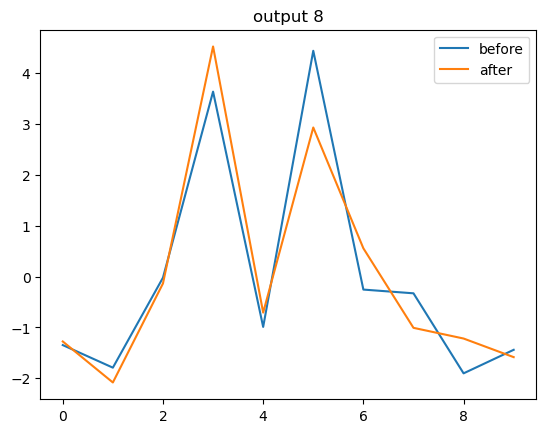

In [49]:
idx = 8
plt.plot(before_out[idx, 0].to('cpu').detach(), label='before')
plt.plot(after_out[idx, 0].to('cpu').detach(), label='after')
plt.title(f'output {idx}')
plt.legend()

In [43]:
before_cor = []
model_s[0].eval()
model_s[0].to(device)

with torch.no_grad():
    for data, target in test_loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        
        # Get predictions from both models
        output_s = model_s[0](data, thresholds, L=0, t=n_steps)
        # Calculate the mean over the time steps
        output_s = torch.mean(output_s, dim=1)
        # Get the predicted classes
        pred_s = output_s.argmax(dim=1)
        # Find the correctly classified samples by model_s[0] but not by model_tmp
        correct_s = (pred_s == target)
        # Store the samples
        before_cor.append(data[correct_s])
        break
# Concatenate all the correct samples into a single tensor
before_cor = torch.cat(before_cor, dim=0)

In [56]:
before_incor = []
before_incor_labels = []
model_s[0].eval()
model_s[0].to(device)

with torch.no_grad():
    for data, target in test_loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        
        # Get predictions from both models
        output_s = model_s[0](data, thresholds, L=0, t=n_steps)
        # Calculate the mean over the time steps
        output_s = torch.mean(output_s, dim=1)
        # Get the predicted classes
        pred_s = output_s.argmax(dim=1)
        # Find the correctly classified samples by model_s[0] but not by model_tmp
        incorrect_s = (pred_s != target)
        # Store the samples
        before_incor.append(data[incorrect_s])
        before_incor_labels.append(target[incorrect_s])
# Concatenate all the correct samples into a single tensor
before_incor = torch.cat(before_incor, dim=0)
before_incor_labels = torch.cat(before_incor_labels, dim=0)

In [54]:
before_cor_out = model_s[0](before_cor, thresholds, L=0, t=n_steps)
before_incor_out = model_s[0](before_incor, thresholds, L=0, t=n_steps)

In [ ]:
for idx in range(20):
    plt.plot(before_cor_out[idx, 0].to('cpu').detach(), label='before')
    plt.title(f'output {idx}')
    plt.legend()
    plt.show()


In [ ]:
for idx in range(20):
    plt.plot(before_incor_out[idx, 0].to('cpu').detach(), label='before')
    plt.title(f'target: {before_incor_labels[idx]}')
    plt.legend()
    plt.show()


In [70]:
ann_model = modelpool(args.model, args.dataset)
ann_sd = torch.load(f'saved_models/cifar10_vgg16_{ckpt_model_idx}.pth', map_location='cpu', weights_only=True)
ann_model.load_state_dict(ann_sd)
validate_ann(ann_model, test_loader, device)

Accuracy of the network on the test images: 95.880000


95.88

In [71]:
ann_cor = []
ann_model.to(device)
ann_model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = ann_model(data)
        pred = output.argmax(dim=1)
        correct = (pred == target)
        ann_cor.append(data[correct])
        break
ann_cor = torch.cat(ann_cor, dim=0)

ann_cor_out = ann_model(ann_cor)

In [56]:
# ann_cor_out = ann_model(before_cor_after_incor[:, 0, :, :, :].to(device))

In [72]:
ann_incor = []
ann_incor_labels = []
ann_model.to(device)
ann_model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = ann_model(data)
        pred = output.argmax(dim=1)
        incorrect = (pred != target)
        ann_incor.append(data[incorrect])
        ann_incor_labels.append(target[incorrect])
ann_incor = torch.cat(ann_incor, dim=0)

ann_incor_out = ann_model(ann_incor)

In [ ]:
for idx in range(20):
    plt.plot(ann_cor_out[idx].to('cpu').detach(), label='before')
    plt.legend()
    plt.show()

In [ ]:
for idx in range(20):
    plt.plot(ann_incor_out[idx].to('cpu').detach(), label='before')
    plt.legend()
    plt.show()

In [73]:
reset_bn_stats(ann_model, device, train_loader, n_steps, layerwise=False, ann=True)
validate_ann(ann_model, test_loader, device)

Accuracy of the network on the test images: 95.840000


95.84

In [74]:
ann_model.to(device)
after_ann_out = ann_model(ann_incor)

In [ ]:
for idx in range(20):
    plt.plot(ann_incor_out[idx].to('cpu').detach(), label='before')
    plt.plot(after_ann_out[idx].to('cpu').detach(), label='after')
    plt.legend()
    plt.show()

#### merging

##### uniform soup

In [119]:
# bn_loader, _ = datapool(args.dataset, 512, 0, shuffle=False)
model_mid = modelpool(args.model, args.dataset)
model_mid = ann_to_snn(model_mid, thresholds, thresholds1, n_steps)
merged_indices = range(0, num_models)

sorted_indices = np.argsort(acc_s)[::-1]
merged_indices = sorted_indices[:4]
# merged_indices = [0, 2]

merged_sds = [sd_s[i] for i in merged_indices]
num_models = len(merged_sds)
merged_weights = [1/num_models]*num_models

sd_mid = interpolate_multi_state_dicts(merged_sds, merged_weights, use_slerp=False)
model_mid.load_state_dict(sd_mid)
model_mid = model_mid.to(device)
acc_mid = validate_snn(model_mid, test_loader, n_steps, device)
print(f'linear acc: {acc_mid}')
reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
acc_mid_reset = validate_snn(model_mid, test_loader, n_steps, device)
print(f'linear acc reset: {acc_mid_reset}')

sd_mid = interpolate_multi_state_dicts(merged_sds, merged_weights, use_slerp=True)
model_mid.load_state_dict(sd_mid)
model_mid = model_mid.to(device)
acc_mid = validate_snn(model_mid, test_loader, n_steps, device)
print(f'slerp acc: {acc_mid}')
reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
acc_mid_reset = validate_snn(model_mid, test_loader, n_steps, device)
print(f'slerp acc reset: {acc_mid_reset}')

Accuracy of the network on the test images: 92.640000
linear acc: 92.64
Accuracy of the network on the test images: 92.510000
linear acc reset: 92.51
Accuracy of the network on the test images: 92.270000
slerp acc: 92.27
Accuracy of the network on the test images: 92.200000
slerp acc reset: 92.2


In [60]:
reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
acc_mid_reset = validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 89.980000


In [45]:
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts(merged_sds, merged_weights, use_slerp=True)
model_mid.load_state_dict(sd_mid)
model_mid = model_mid.to(device)
# acc_mid = validate_snn(model_mid, test_loader, n_steps, device)
# print(f'slerp acc: {acc_mid}')
reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
acc_mid_reset = validate_snn(model_mid, test_loader, n_steps, device)
print(f'slerp acc reset: {acc_mid_reset}')

Accuracy of the network on the test images: 92.360000
slerp acc reset: 92.36


##### greedy soup

1. sort all models according to their test acc (descending)
2. add the next best model to the soup
3. remain the model only if it has a better test acc than the current soup
4. repeat step 2 and 3 until no more models can be added

In [136]:
def grid_search(model_1, model_2, grid, use_slerp=False):
    t_best = None
    acc_best = -1
    for t in grid:
        sd_mid = interpolate_state_dicts(model_1.state_dict(), model_2.state_dict(), t, use_slerp=use_slerp)
        model_mid.load_state_dict(sd_mid)
        acc_mid = validate_snn(model_mid, test_loader, n_steps, device, verbose=0)
        if acc_mid > acc_best:
            acc_best = acc_mid
            t_best = t
    return sd_mid, acc_best, t_best
        

# 1: sort indices by acc_s in descending order
sorted_indices = np.argsort(acc_s)[::-1]
acc_cur = -1
model_mid = None
num_merged = 0
merged_indices = []
use_slerp = True
print(f"use_slerp: {use_slerp}")
for i in sorted_indices:
    print(f"test model {i}")
    if model_mid is None:
        model_mid = deepcopy(model_s[i])
        acc_cur = acc_s[i]
        print(f"add model {i}, current acc: {acc_cur}" + "\n")
        num_merged += 1
        merged_indices.append(i)
    else:
        sd_mid_ori = deepcopy(model_mid.state_dict())
        t = 1 / (num_merged + 1)
        sd_mid = interpolate_state_dicts(model_mid.state_dict(), model_s[i].state_dict(), t, use_slerp=use_slerp)
        model_mid.load_state_dict(sd_mid)
        acc_mid = validate_snn(model_mid, test_loader, n_steps, device, verbose=0)
        print(f'acc: {acc_mid}')
        # reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
        # acc_mid_reset = validate_snn(model_mid, test_loader, n_steps, device, verbose=0)
        # print(f'reset acc: {acc_mid_reset}')

        # if acc_mid > acc_mid_reset:
        #     model_mid.load_state_dict(sd_mid)
        #     acc_best = acc_mid
        # else:
        #     acc_best = acc_mid_reset
        if acc_mid > acc_cur: # use acc_mid for comparison or acc_best
            acc_cur = acc_mid
            print(f"add model {i}, current acc: {acc_cur}" + "\n")
            num_merged += 1
            merged_indices.append(i)
        else:
            print('\n')
            model_mid.load_state_dict(sd_mid_ori)

use_slerp: True
test model 11
add model 11, current acc: 92.61

test model 28


TypeError: validate_snn() got multiple values for argument 'verbose'

In [51]:
for _ in range(10):
    reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
    validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 92.350000
Accuracy of the network on the test images: 92.360000
Accuracy of the network on the test images: 92.530000
Accuracy of the network on the test images: 92.180000
Accuracy of the network on the test images: 92.220000
Accuracy of the network on the test images: 92.540000
Accuracy of the network on the test images: 92.460000
Accuracy of the network on the test images: 92.360000
Accuracy of the network on the test images: 92.360000
Accuracy of the network on the test images: 92.370000


#### grid search on t

In [14]:
sorted_indices

array([11,  0, 10, 12,  1,  4,  2,  8,  9,  6, 13,  7,  5,  3])

In [13]:
acc_s

[92.44,
 92.42,
 92.39,
 92.09,
 92.4,
 92.09,
 92.18,
 92.13,
 92.38,
 92.3,
 92.43,
 92.61,
 92.42,
 92.17]

In [61]:
# two models
merged_indices = [0, 1]
merged_sds = [sd_s[i] for i in merged_indices]
t_s = np.linspace(0.52, 0.53, 20)
acc_t_s = []
for t in t_s:
    merged_weights = [t, 1-t]
    sd_mid = interpolate_multi_state_dicts(merged_sds, merged_weights, use_slerp=True)
    # sd_mid = interpolate_state_dicts(merged_sds[0], merged_sds[1], 0.5, use_slerp=True)
    model_mid.load_state_dict(sd_mid)
    model_mid = model_mid.to(device)
    acc_mid = validate_snn(model_mid, test_loader, n_steps, device)
    acc_t_s.append(acc_mid)
t_acc_dict = {t: acc for t, acc in zip(t_s, acc_t_s)}

Accuracy of the network on the test images: 90.010000
Accuracy of the network on the test images: 89.870000
Accuracy of the network on the test images: 89.810000
Accuracy of the network on the test images: 89.930000
Accuracy of the network on the test images: 90.310000
Accuracy of the network on the test images: 89.900000
Accuracy of the network on the test images: 90.160000
Accuracy of the network on the test images: 89.950000
Accuracy of the network on the test images: 90.100000
Accuracy of the network on the test images: 89.940000
Accuracy of the network on the test images: 89.790000
Accuracy of the network on the test images: 89.980000
Accuracy of the network on the test images: 90.270000
Accuracy of the network on the test images: 90.130000
Accuracy of the network on the test images: 89.920000
Accuracy of the network on the test images: 90.060000
Accuracy of the network on the test images: 89.710000
Accuracy of the network on the test images: 90.000000
Accuracy of the network on t

In [42]:
t_acc_dict

{0.4: 92.03,
 0.4105263157894737: 92.22,
 0.4210526315789474: 92.17,
 0.43157894736842106: 92.22,
 0.4421052631578948: 92.16,
 0.45263157894736844: 92.24,
 0.4631578947368421: 92.31,
 0.4736842105263158: 92.2,
 0.4842105263157895: 92.02,
 0.49473684210526314: 92.25,
 0.5052631578947369: 92.19,
 0.5157894736842106: 92.13,
 0.5263157894736842: 92.16,
 0.5368421052631579: 92.48,
 0.5473684210526315: 92.04,
 0.5578947368421052: 92.16,
 0.5684210526315789: 92.18,
 0.5789473684210527: 92.27,
 0.5894736842105264: 92.47,
 0.6: 92.15}

In [46]:
t = 0.5
merged_weights = [t, 1-t]
sd_mid = interpolate_multi_state_dicts(merged_sds, merged_weights, use_slerp=True)
# sd_mid = interpolate_state_dicts(merged_sds[0], merged_sds[1], 0.5, use_slerp=True)
model_mid.load_state_dict(sd_mid)
model_mid = model_mid.to(device)
acc_mid = validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 91.890000


#### reset bn

In [47]:
reset_acc_s = []
# bn_loader, _ = datapool(args.dataset, 128, 0, shuffle=True)
for _ in range(10):
    bn_loader = train_loader
    model_mid.load_state_dict(sd_mid)
    reset_bn_stats(model_mid, device, bn_loader, n_steps, layerwise=False)
    reset_acc_mid = validate_snn(model_mid, test_loader, n_steps, device)
    # print("Training acc", validate_snn(model_mid, bn_loader, n_steps, device))
    reset_acc_s.append(reset_acc_mid)

Accuracy of the network on the test images: 92.310000
Accuracy of the network on the test images: 92.200000
Accuracy of the network on the test images: 92.360000
Accuracy of the network on the test images: 92.280000
Accuracy of the network on the test images: 92.140000
Accuracy of the network on the test images: 92.240000
Accuracy of the network on the test images: 92.120000
Accuracy of the network on the test images: 91.870000
Accuracy of the network on the test images: 92.560000
Accuracy of the network on the test images: 92.580000


In [38]:
max(reset_acc_s)

92.68

#### try fine-tuning to tune bn statistics

In [79]:
def train_snn(train_dataloader, test_dataloader, model, epochs, device, loss_fn, lr=0.1, wd=5e-4):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.9,weight_decay=wd) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs,verbose=True)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        length = 0
        total = 0
        correct = 0
        for img, label in train_dataloader:
            img = add_dimension(img,n_steps)
            img = img.cuda(device)
            
            labels = label.cuda(device)
            outputs = model(img,thresholds,L=0,t=n_steps) 
            outputs = torch.sum(outputs,1)
            optimizer.zero_grad()
            loss = loss_fn(outputs/n_steps, labels)

            with torch.autograd.set_detect_anomaly(True):
                loss.backward()
                optimizer.step()
                
            epoch_loss += loss.item()*img.shape[0]
            length += len(label)
            _, predicted = torch.max(outputs.data, 1)

            #print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if total%(256*8) == 0:
                print('Epoch:%d, Accuracy of the snn network on the %d train images: %f, loss:%f'%(epoch,total,100 * correct / total,epoch_loss/total))
        print('Epoch:%d, Accuracy of the snn network on the %d train images: %f, loss:%f'%(epoch,total,100 * correct / total,epoch_loss/total))
        scheduler.step()
        validate_snn(model, test_dataloader, n_steps, thresholds, device)
model_mid.load_state_dict(sd_mid) 
train_snn(train_loader, test_loader, model_mid, 5, device, criterion, lr=1e-5, wd=5e-4)

In [119]:
th = np.load('cifar10_vgg16_0_threshold_all_noaug2.npy')

In [32]:
acc = np.load('logs/cifar10_vgg16_3_updated_snn1_test_acc_1_v22.npy')

In [33]:
acc

array(91.95)

#### bn statistics simple tricks

In [68]:
model_test = deepcopy(model_s[0])
model_test.float()
validate_snn(model_test, test_loader, n_steps, device)

Accuracy of the network on the test images: 92.440000


92.44

##### continue update bn statistics

In [ ]:
model_test = deepcopy(model_s[0])
model_test.float().train().to(device)
for module in model_test.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.momentum = None
test_acc_s = []

In [82]:
for _ in range(10):
    model_test.train().to(device)
    with torch.no_grad():
        for data, _ in train_loader:
            data = add_dimension(data, n_steps)
            data = data.to(device)
            model_test(data, L=0, t=n_steps)
            model_test.zero_grad()
    model_test.eval()
    test_acc_s.append(validate_snn(model_test, test_loader, n_steps, device))

Accuracy of the network on the test images: 92.330000
Accuracy of the network on the test images: 92.360000
Accuracy of the network on the test images: 92.230000
Accuracy of the network on the test images: 92.080000
Accuracy of the network on the test images: 92.060000
Accuracy of the network on the test images: 92.020000
Accuracy of the network on the test images: 91.970000
Accuracy of the network on the test images: 91.910000
Accuracy of the network on the test images: 92.050000
Accuracy of the network on the test images: 92.190000


#### snn distillation

In [93]:
model_merge_1 = deepcopy(model_s[0]).float()
model_merge_2 = deepcopy(model_s[1]).float()
validate_snn(model_merge_1, test_loader, n_steps, device)
validate_snn(model_merge_2, test_loader, n_steps, device)
validate_snn_ensemble([model_merge_1, model_merge_2], test_loader, n_steps, device)

Accuracy of the network on the test images: 92.440000
Accuracy of the network on the test images: 92.420000
Accuracy of the network on the test images: 93.420000


93.42

In [109]:
model_mid = deepcopy(model_s[0]).float()
sd_mid = interpolate_state_dicts(model_merge_1.state_dict(), model_merge_2.state_dict(), 0.5)
model_mid.load_state_dict(sd_mid)
validate_snn(model_mid, test_loader, n_steps, device)
# reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
# validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 91.870000


91.87

In [144]:
sd_mid = interpolate_state_dicts(model_merge_1.state_dict(), model_merge_2.state_dict(), 0.5)

In [119]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

trans_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
train_data = datasets.CIFAR10('datasets', train=True, transform=trans_train, download=True)
disllation_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [137]:
import torch.nn.functional as F

model_mid.load_state_dict(sd_mid)
# optimizer = torch.optim.SGD(model_mid.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model_mid.parameters(), lr=1.5e-5, weight_decay=5e-4)
total_epochs = 10
num_batches = len(disllation_dataloader)
total_steps = total_epochs * num_batches
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, verbose=True)
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()
for epoch in range(total_epochs):
    model_mid = model_mid.to(device).train().float()
    model_merge_1.eval().to(device).float()
    model_merge_2.eval().to(device).float()
    
    epoch_loss = 0
    epoch_loss_mse = 0
    epoch_loss_ce = 0
    length = 0
    total = 0
    correct = 0
    for img, label in disllation_dataloader:
        img = add_dimension(img, n_steps)
        img = img.to(device)
        
        labels = label.cuda(device)
        outputs = model_mid(img, L=0, t=n_steps) 
        outputs = torch.mean(outputs, 1)
        
        outputs_1 = model_merge_1(img, L=0, t=n_steps)
        outputs_1 = torch.mean(outputs_1,1)
        outputs_2 = model_merge_2(img, L=0, t=n_steps)
        outputs_2 = torch.mean(outputs_2,1)
        outputs_ensemble = (outputs_1 + outputs_2) / 2
        
        optimizer.zero_grad()
        temperature = 3
        mse_loss = F.kl_div(
                    F.log_softmax(outputs / temperature, dim=1),
                    F.softmax(outputs_ensemble / temperature, dim=1),
                    reduction="batchmean")
        # mse_loss = torch.tensor(0).to(device)
        ce_loss = ce_criterion(outputs, labels)
        alpha = 0.8
        loss = alpha * mse_loss + ce_loss * (1-alpha)

        with torch.autograd.set_detect_anomaly(True):
            loss.backward()
            optimizer.step()
            
        epoch_loss += loss.item()*img.shape[0]
        epoch_loss_mse += mse_loss.item()*img.shape[0]
        epoch_loss_ce += ce_loss.item()*img.shape[0]
        length += len(label)
        _, predicted = torch.max(outputs.data, 1)

        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print('Epoch:%d, Accuracy of the snn network on the %d train images: %f, loss:%f'%(epoch,total,100 * correct / total,epoch_loss/total))
        if total%(128*100) == 0:
            cur_acc = validate_snn(model_mid, test_loader, n_steps, device, verbose=0)
            print(f'Batch {total//(128*100)}, acc: {cur_acc}')
    print('Epoch:%d, Accuracy of the snn network on the %d train images: %f, loss:%f, mse_loss:%f, ce_loss:%f'%(epoch,total,100 * correct / total,epoch_loss/total, epoch_loss_mse/total, epoch_loss_ce/total))
    scheduler.step()
    validate_snn(model_mid, test_loader, n_steps, device)

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch 1, acc: 91.33
Batch 2, acc: 91.68
Batch 3, acc: 91.69
Epoch:0, Accuracy of the snn network on the 50000 train images: 96.700000, loss:0.035763, mse_loss:0.011126, ce_loss:0.134309
Accuracy of the network on the test images: 91.580000
Batch 1, acc: 91.7
Batch 2, acc: 91.9
Batch 3, acc: 92.05
Epoch:1, Accuracy of the snn network on the 50000 train images: 96.976000, loss:0.033190, mse_loss:0.010924, ce_loss:0.122254
Accuracy of the network on the test images: 91.860000
Batch 1, acc: 92.04
Batch 2, acc: 91.6
Batch 3, acc: 91.72
Epoch:2, Accuracy of the snn network on the 50000 train images: 97.088000, loss:0.032057, mse_loss:0.010861, ce_loss:0.116842
Accuracy of the network on the test images: 91.120000
Batch 1, acc: 92.06
Batch 2, acc: 91.78
Batch 3, acc: 91.79
Epoch:3, Accuracy of the snn network on the 50000 train images: 97.282000, loss:0.030613, mse_loss:0.010742, ce_loss:0.110098
Accuracy of the network on the test images: 91.840000
Batch 1, acc: 92.36
Batch 2, acc: 91.82
Bat

In [ ]:
for key in sd_mid:
    if "running" in key:
        plt.plot(sd_mid[key].flatten(), label='before')
        plt.plot(model_mid.state_dict()[key].to('cpu').detach().flatten(), label='after')
        plt.title(key)
        plt.legend()
        plt.show()

In [ ]:
for key in sd_mid:
    if "running" not in key and 'batch' not in key:
        # plt.plot(sd_mid[key].flatten(), label='before')
        plt.plot(model_merge_1.state_dict()[key].to('cpu').detach().flatten(), label='before')
        plt.plot(model_mid.state_dict()[key].to('cpu').detach().flatten(), label='after')
        plt.title(key)
        plt.legend()
        plt.show()

##### train bn statistics

In [194]:
import torch

import torch.nn as nn

class TrainableBatchNorm2d(nn.Module):
    def __init__(self, bn_layer):
        super(TrainableBatchNorm2d, self).__init__()
        self.num_features = bn_layer.num_features
        self.eps = bn_layer.eps
        self.weight = nn.Parameter(bn_layer.weight.clone())
        self.bias = nn.Parameter(bn_layer.bias.clone())
        self.running_mean = nn.Parameter(bn_layer.running_mean.clone())
        self.running_var = nn.Parameter(bn_layer.running_var.clone())

    def forward(self, x):
        scale = self.weight / (self.running_var + self.eps).sqrt()
        shift = self.bias - self.running_mean * scale
        return x * scale[None, :, None, None] + shift[None, :, None, None]

def replace_by_trainable_bn(model, device):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, TrainableBatchNorm2d(module).to(device))
        else:
            replace_by_trainable_bn(module, device)
# Example usage:
# Assuming `bn_layer` is an instance of nn.BatchNorm2d
# trainable_bn = TrainableBatchNorm2d(bn_layer)
# output = trainable_bn(input_tensor)

In [193]:
model_mid = deepcopy(model_s[0])
model_mid.load_state_dict(sd_mid)
model_mid.to(device).float()
replace_by_trainable_bn(model_mid, device)

In [181]:
validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 91.860000


91.86

In [212]:
import torch.nn.functional as F
model_mid = deepcopy(model_s[0])
model_mid.load_state_dict(sd_mid)
replace_by_trainable_bn(model_mid, device)
# optimizer = torch.optim.SGD(model_mid.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-4)
optimizer = torch.optim.AdamW(model_mid.parameters(), lr=1e-4, weight_decay=5e-4)
# freeze all parameters except weights and bias in TrainableBatchNorm2d
for m in model_mid.modules():
    if isinstance(m, TrainableBatchNorm2d):
        m.weight.requires_grad = True
        m.bias.requires_grad = False
    else:
        for param in m.parameters():
            param.requires_grad = False

total_epochs = 5
num_batches = len(disllation_dataloader)
total_steps = total_epochs * num_batches
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, verbose=True)
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()
for epoch in range(total_epochs):
    model_mid = model_mid.to(device).float()
    model_merge_1.eval().to(device).float()
    model_merge_2.eval().to(device).float()
    
    epoch_loss = 0
    epoch_loss_mse = 0
    epoch_loss_ce = 0
    length = 0
    total = 0
    correct = 0
    for img, label in disllation_dataloader:
        img = add_dimension(img, n_steps)
        img = img.to(device)
        
        labels = label.cuda(device)
        outputs = model_mid(img, L=0, t=n_steps) 
        outputs = torch.mean(outputs, 1)
        
        outputs_1 = model_merge_1(img, L=0, t=n_steps)
        outputs_1 = torch.mean(outputs_1,1)
        outputs_2 = model_merge_2(img, L=0, t=n_steps)
        outputs_2 = torch.mean(outputs_2,1)
        outputs_ensemble = (outputs_1 + outputs_2) / 2
        
        optimizer.zero_grad()
        temperature = 1
        mse_loss = F.kl_div(
                    F.log_softmax(outputs / temperature, dim=1),
                    F.softmax(outputs_ensemble / temperature, dim=1),
                    reduction="batchmean")
        # mse_loss = torch.tensor(0).to(device)
        ce_loss = ce_criterion(outputs, labels)
        alpha = 1
        loss = alpha * mse_loss + ce_loss * (1-alpha)

        with torch.autograd.set_detect_anomaly(True):
            loss.backward()
            optimizer.step()
            
        epoch_loss += loss.item()*img.shape[0]
        epoch_loss_mse += mse_loss.item()*img.shape[0]
        epoch_loss_ce += ce_loss.item()*img.shape[0]
        length += len(label)
        _, predicted = torch.max(outputs.data, 1)

        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print('Epoch:%d, Accuracy of the snn network on the %d train images: %f, loss:%f'%(epoch,total,100 * correct / total,epoch_loss/total))
        if total%(128*100) == 0:
            cur_acc = validate_snn(model_mid, test_loader, n_steps, device, verbose=0)
            print(f'Batch {total//(128*100)}, acc: {cur_acc}')
    print('Epoch:%d, Accuracy of the snn network on the %d train images: %f, loss:%f, mse_loss:%f, ce_loss:%f'%(epoch,total,100 * correct / total,epoch_loss/total, epoch_loss_mse/total, epoch_loss_ce/total))
    scheduler.step()
    validate_snn(model_mid, test_loader, n_steps, device)

/home/xingyu/anaconda3/envs/default/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch 1, acc: 92.21
Batch 2, acc: 92.07
Batch 3, acc: 92.1
Epoch:0, Accuracy of the snn network on the 50000 train images: 97.558000, loss:0.038533, mse_loss:0.038533, ce_loss:0.120966
Accuracy of the network on the test images: 92.190000
Batch 1, acc: 91.95
Batch 2, acc: 92.13
Batch 3, acc: 92.39
Epoch:1, Accuracy of the snn network on the 50000 train images: 97.496000, loss:0.039244, mse_loss:0.039244, ce_loss:0.125815
Accuracy of the network on the test images: 92.260000
Batch 1, acc: 92.05
Batch 2, acc: 91.9
Batch 3, acc: 92.22
Epoch:2, Accuracy of the snn network on the 50000 train images: 97.450000, loss:0.038758, mse_loss:0.038758, ce_loss:0.126071
Accuracy of the network on the test images: 92.230000
Batch 1, acc: 91.92
Batch 2, acc: 92.23
Batch 3, acc: 92.26
Epoch:3, Accuracy of the snn network on the 50000 train images: 97.408000, loss:0.039557, mse_loss:0.039557, ce_loss:0.125944
Accuracy of the network on the test images: 92.270000


KeyboardInterrupt: 

#### Compare finetuned models

In [28]:
data, target = next(iter(train_loader))
data = add_dimension(data, n_steps)
data, target = data.to(device), target.to(device)

In [11]:
model_merge_1 = deepcopy(model_s[0]).to(device)
model_merge_2 = deepcopy(model_s[1]).to(device)

In [60]:
L = 1
outputs_1 = model_merge_1(data, L=L, t=n_steps)
outputs_1 = torch.mean(outputs_1, 1)
outputs_2 = model_merge_2(data, L=L, t=n_steps)
outputs_2 = torch.mean(outputs_2, 1)

In [73]:
max_diff_s = []
for L in range(0, 16):
    outputs_1 = model_merge_1(data, L=L, t=n_steps)
    outputs_1 = torch.mean(outputs_1, 1)
    outputs_2 = model_merge_2(data, L=L, t=n_steps)
    outputs_2 = torch.mean(outputs_2, 1)
    diff = torch.abs(outputs_1 - outputs_2)
    max_diff = torch.max(diff)
    max_diff_s.append(max_diff.item())
    print(f'L={L}, max_diff={max_diff}')

L=0, max_diff=5.023438453674316
L=1, max_diff=0.20188574492931366
L=2, max_diff=0.19557975232601166
L=3, max_diff=0.13197259604930878
L=4, max_diff=0.19841402769088745
L=5, max_diff=0.12946902215480804
L=6, max_diff=0.12687665224075317
L=7, max_diff=0.14906498789787292
L=8, max_diff=0.07979712635278702
L=9, max_diff=0.058995846658945084
L=10, max_diff=0.07041503489017487
L=11, max_diff=0.03931347280740738
L=12, max_diff=0.04810955747961998
L=13, max_diff=0.2804771661758423
L=14, max_diff=0.045754674822092056
L=15, max_diff=0.0835646241903305


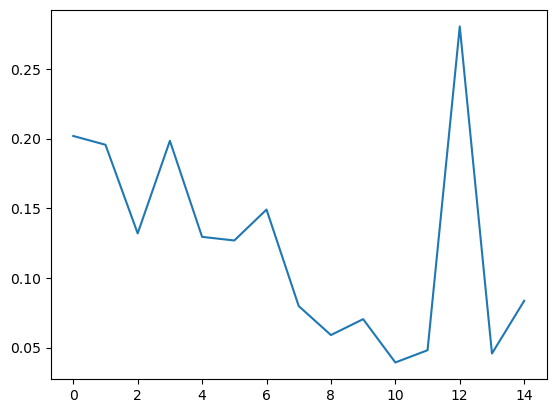

In [77]:
plt.plot(max_diff_s[1:])

In [102]:
param_max_diff_s = []
for param_1, param_2 in zip(model_merge_1.parameters(), model_merge_2.parameters()):
    diff = torch.abs(param_1 - param_2)
    max_diff = torch.max(diff)
    param_max_diff_s.append(max_diff.item())
    # print(f'max_diff={max_diff}')

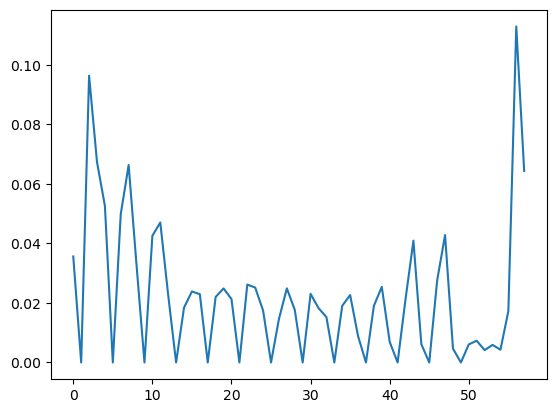

In [103]:
plt.plot(param_max_diff_s)

##### sign conflict

In [27]:
diff_sign_s = []
total = []
for (name_1, param_1), (name_2, param_2) in zip(model_merge_1.named_parameters(), model_merge_2.named_parameters()):
    diff = param_1.sign() * param_2.sign()
    diff_sign = torch.sum(diff == -1)
    total = param_1.numel()
    diff_sign_s.append(diff_sign.item())
    print(name_1, f'diff_sign={diff_sign}, pct={diff_sign/total *100 :.2f}%')

layer1.0.layer.module.weight diff_sign=60, pct=3.47%
layer1.0.layer.module.bias diff_sign=0, pct=0.00%
layer1.1.layer.module.weight diff_sign=0, pct=0.00%
layer1.1.layer.module.bias diff_sign=2, pct=3.12%
layer1.4.layer.module.weight diff_sign=2367, pct=6.42%
layer1.4.layer.module.bias diff_sign=11, pct=17.19%
layer1.5.layer.module.weight diff_sign=0, pct=0.00%
layer1.5.layer.module.bias diff_sign=5, pct=7.81%
layer2.0.layer.module.weight diff_sign=6230, pct=8.45%
layer2.0.layer.module.bias diff_sign=16, pct=12.50%
layer2.1.layer.module.weight diff_sign=0, pct=0.00%
layer2.1.layer.module.bias diff_sign=6, pct=4.69%
layer2.4.layer.module.weight diff_sign=10955, pct=7.43%
layer2.4.layer.module.bias diff_sign=23, pct=17.97%
layer2.5.layer.module.weight diff_sign=0, pct=0.00%
layer2.5.layer.module.bias diff_sign=2, pct=1.56%
layer3.0.layer.module.weight diff_sign=25405, pct=8.61%
layer3.0.layer.module.bias diff_sign=43, pct=16.80%
layer3.1.layer.module.weight diff_sign=0, pct=0.00%
layer3.

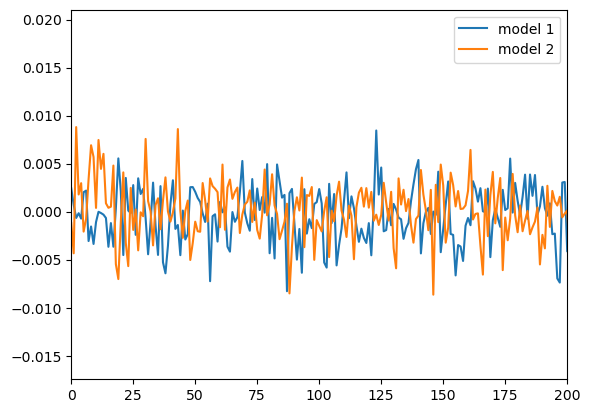

In [23]:
param_name = 'layer3.4.layer.module.weight'
param_1 = model_merge_1.state_dict()[param_name]
param_2 = model_merge_2.state_dict()[param_name]
diff = param_1.sign() * param_2.sign()
diff_value_1 = param_1[diff == -1]
diff_value_2 = param_2[diff == -1]

plt.plot(diff_value_1.detach().cpu(), label='model 1')
plt.plot(diff_value_2.detach().cpu(), label='model 2')
plt.xlim(0, 200)
plt.legend()
plt.show()


##### redundancy in the task vector

finding: not so many redundancy in the task vector

In [35]:
snn_init.to('cpu')
model_merge_1.to('cpu')
sd_init = snn_init.state_dict()
sd_1 = model_merge_1.state_dict()

sd_task_vector = {k: sd_1[k] - sd_init[k] for k in sd_1.keys()}



Accuracy of the network on the test images: 91.910000
Accuracy of the network on the test images: 92.180000
Accuracy of the network on the test images: 91.960000
Accuracy of the network on the test images: 91.770000
Accuracy of the network on the test images: 92.070000


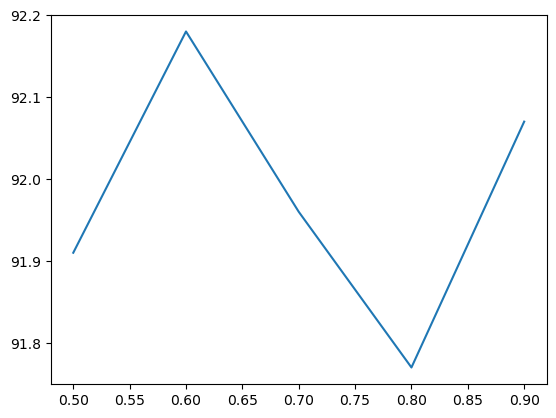

In [ ]:
import torch
import torch.nn.utils.prune as prune
import torch.nn as nn

def keep_top_k_pruning(model, k):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            parameters_to_prune.append((module, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=1 - k,
    )
    
    # layerwise pruning
    # for module, _ in parameters_to_prune:
    #     prune.l1_unstructured(module, name='weight', amount=1-k)
        
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')
    return model


snn_init.to('cpu')
model_merge = deepcopy(model_s[3])
model_merge.to('cpu')
sd_init = snn_init.state_dict()
sd_1 = model_merge.state_dict()
sd_task_vector = {k: sd_1[k] - sd_init[k] for k in sd_1.keys()}

pruned_test_acc_s = []
sparsity_s = np.arange(0.5, 1.0, 0.1)
for k in sparsity_s:
    model_pruned = deepcopy(model_s[3])
    model_pruned.load_state_dict(sd_task_vector)
    model_pruned = keep_top_k_pruning(model_pruned, k)
    sd_pruned_task_vector = model_pruned.state_dict()
    sd_pruned = {k: sd_init[k] + sd_pruned_task_vector[k] for k in sd_init.keys()}
    model_pruned.load_state_dict(sd_pruned)
    
    pruned_acc = validate_snn(model_pruned, test_loader, n_steps, device)
    pruned_test_acc_s.append(pruned_acc)
plt.plot(sparsity_s, pruned_test_acc_s)

In [57]:
validate_snn(model_s[1], test_loader, n_steps, device)

Accuracy of the network on the test images: 92.420000


92.42

##### ties merging

if sign conflicts when merging a pair of parameters, choose the one with larger magnitude

In [94]:
def ties_merging(sd_1, sd_2):
    sd_merged = {}
    for key in sd_1.keys():
        if 'batch' in key:
            sd_merged[key] = sd_1[key]
        if key in sd_2:
            if 'running' in key:
                sd_merged[key] = (sd_1[key] + sd_2[key]) / 2
            param1 = sd_1[key]
            param2 = sd_2[key]
            sign_conflict = (param1.sign() * param2.sign()) == -1
            larger_magnitude = torch.abs(param1) > torch.abs(param2)
            sd_merged[key] = torch.where(sign_conflict, torch.where(larger_magnitude, param1, param2), (param1 + param2) / 2)
    return sd_merged

In [ ]:
model_merge_1 = deepcopy(model_s[1])
model_merge_2 = deepcopy(model_s[2])

# normal merge
model_merge_mid = deepcopy(model_s[0])
sd_mid = interpolate_state_dicts(model_merge_1.state_dict(), model_merge_2.state_dict(), 0.5)
model_merge_mid.load_state_dict(sd_mid)
validate_snn(model_merge_mid, test_loader, n_steps, device)
# ties merge
sd_mid = ties_merging(model_merge_1.state_dict(), model_merge_2.state_dict())
model_merge_mid.load_state_dict(sd_mid)
validate_snn(model_merge_mid, test_loader, n_steps, device)
reset_bn_stats(model_merge_mid, device, train_loader, n_steps, layerwise=False, ann=False)
validate_snn(model_merge_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 92.060000
Accuracy of the network on the test images: 92.390000
Accuracy of the network on the test images: 92.200000


92.2

In [88]:
def PFM_outputs(model_merge_s, model_merged, data, L, n_steps):
    outputs_s = [model(data, L=L, t=n_steps) for model in model_merge_s]
    outputs_avg = torch.zeros_like(outputs_s[0])
    for outputs in outputs_s:
        outputs_avg += outputs
    outputs_avg /= len(outputs_s)
    outputs = model_merged(outputs_avg, L=0, t=n_steps, prev_L=L).mean(1)
    return outputs

In [111]:
model_merge_s = [deepcopy(model_s[i]) for i in [0, 2]]
for model in model_merge_s:
    model.to(device)
    model.eval()
num_models = len(model_merge_s)
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)

sd_mid_ties = ties_merging(model_merge_s[0].state_dict(), model_merge_s[1].state_dict())
L = 12
# replace the first L group parameters by sd_mid_ties
counter = 0
for k in sd_mid:
    if counter >= L:
        break
    sd_mid[k] = sd_mid_ties[k]
    if 'running' in k:
        counter += 1

model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 91.890000


91.89

In [96]:
model_merge_s = [deepcopy(model_s[i]) for i in [0, 1]]
for model in model_merge_s:
    model.to(device)
    model.eval()
num_models = len(model_merge_s)
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)

L = 5
model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

total = 0
correct = 0
for data, target in test_loader:
    data = add_dimension(data, n_steps)
    data, target = data.to(device), target.to(device)
    outputs = PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
    total += target.size(0)
    correct += (outputs.argmax(1) == target).sum().item()
print('Accuracy of the network on the test images: %f' % (100 * correct / total), f", L={L}")
acc = 100 * correct / total

Accuracy of the network on the test images: 92.980000 , L=5


#### PFM

In [15]:
acc_s = np.array(acc_s)
print(acc_s)
sorted_indices = np.argsort(acc_s)[::-1]
print(sorted_indices)
print(acc_s[sorted_indices])

[92.37 92.43 92.37 92.45 92.3  92.42 92.72 92.57 92.37 92.57 92.38 92.69]
[ 6 11  9  7  3  1  5 10  8  2  0  4]
[92.72 92.69 92.57 92.57 92.45 92.43 92.42 92.38 92.37 92.37 92.37 92.3 ]


In [18]:
validate_snn_ensemble([model_s[6], model_s[11]], test_loader, n_steps, device)

Accuracy of the network on the test images: 93.450000


93.45

##### play with the PFM

In [19]:
def PFM_outputs(model_merge_s, model_merged, data, L, n_steps):
    outputs_s = [model(data, L=L, t=n_steps) for model in model_merge_s]
    outputs_avg = torch.zeros_like(outputs_s[0])
    for outputs in outputs_s:
        outputs_avg += outputs
    outputs_avg /= len(outputs_s)
    outputs = model_merged(outputs_avg, L=0, t=n_steps, prev_L=L).mean(1)
    return outputs

In [20]:
model_merge_s = [deepcopy(model_s[i]) for i in sorted_indices[:2]]
for model in model_merge_s:
    model.to(device)
    model.eval()
num_models = len(model_merge_s)
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)
model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

L = 2
total = 0
correct = 0
for data, target in test_loader:
    data = add_dimension(data, n_steps)
    data, target = data.to(device), target.to(device)
    outputs = PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
    total += target.size(0)
    correct += (outputs.argmax(1) == target).sum().item()
print('Accuracy of the network on the test images: %f' % (100 * correct / total), f", L={L}")
acc = 100 * correct / total

Accuracy of the network on the test images: 92.510000 , L=2


reset

In [38]:
model_mid = deepcopy(model_s[0])
model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

L = 2

# reset bn stats
for m in model_mid.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.reset_running_stats()
        m.training = True
        m.momentum = None

for model in model_merge_s:
    model.to(device)
    model.eval()
model_mid.train()

for data, _ in train_loader:
    data = add_dimension(data, n_steps)
    data = data.to(device)
    PFM_outputs(model_merge_s, model_mid, data, L, n_steps)

# test
model_mid.eval()
total = 0
correct = 0
for data, target in test_loader:
    data = add_dimension(data, n_steps)
    data, target = data.to(device), target.to(device)
    outputs = PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
    total += target.size(0)
    correct += (outputs.argmax(1) == target).sum().item()
print('Accuracy of the network on the test images: %f' % (100 * correct / total), f", L={L}")
acc = 100 * correct / total

Accuracy of the network on the test images: 92.970000 , L=2


##### Test all Ls

In [ ]:
# # test ood

# model_mid = deepcopy(model_s[0])
# sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)
# model_mid.load_state_dict(sd_mid)
# model_mid.to(device).eval()

# id_acc_1 = validate_snn(model_merge_s[0], test_loader, n_steps, device, verbose=0)
# id_acc_2 = validate_snn(model_merge_s[1], test_loader, n_steps, device, verbose=0)
# id_acc_mid = validate_snn(model_mid, test_loader, n_steps, device, verbose=0)
# ood_acc_1 = validate_snn(model_merge_s[0], ood_test_loader, n_steps, device, verbose=0)
# ood_acc_2 = validate_snn(model_merge_s[1], ood_test_loader, n_steps, device, verbose=0)
# ood_acc_mid = validate_snn(model_mid, ood_test_loader, n_steps, device, verbose=0)
# print(f'id_acc_1: {id_acc_1}, id_acc_2: {id_acc_2}, id_acc_mid: {id_acc_mid}')
# print(f'ood_acc_1: {ood_acc_1}, ood_acc_2: {ood_acc_2}, ood_acc_mid: {ood_acc_mid}')

In [22]:
model_merge_s = [deepcopy(model_s[i]) for i in sorted_indices[:3]]
for model in model_merge_s:
    model.to(device)
    model.eval()
num_models = len(model_merge_s)
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)
model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

cur_test_loader = test_loader
validate_snn(model_mid, cur_test_loader, n_steps, device) # direct merge
test_acc_s = []
for L in range(1, 17):
    total = 0
    correct = 0
    for data, target in cur_test_loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        outputs = PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
        total += target.size(0)
        correct += (outputs.argmax(1) == target).sum().item()

    print('Accuracy of the network on the test images: %f' % (100 * correct / total), f", L={L}")
    acc = 100 * correct / total
    test_acc_s.append(acc)

Accuracy of the network on the test images: 92.350000
Accuracy of the network on the test images: 92.620000 , L=1
Accuracy of the network on the test images: 92.790000 , L=2
Accuracy of the network on the test images: 92.960000 , L=3
Accuracy of the network on the test images: 93.150000 , L=4
Accuracy of the network on the test images: 93.320000 , L=5
Accuracy of the network on the test images: 93.680000 , L=6
Accuracy of the network on the test images: 93.830000 , L=7
Accuracy of the network on the test images: 93.960000 , L=8
Accuracy of the network on the test images: 94.000000 , L=9
Accuracy of the network on the test images: 93.850000 , L=10
Accuracy of the network on the test images: 93.880000 , L=11
Accuracy of the network on the test images: 94.070000 , L=12
Accuracy of the network on the test images: 93.990000 , L=13
Accuracy of the network on the test images: 93.970000 , L=14
Accuracy of the network on the test images: 94.070000 , L=15
Accuracy of the network on the test imag

reset

Finding: 
1. when L is large, reset almost brings no difference if not worse
2. when L is small, performance of reset is inconsistent. Sometimes it is better, sometimes it is worse. When merging two models, it can bring some improvement. When merging three models, the improvement is less pronounced.

So perhaps it's not recommended to reset

In [40]:
model_merge_s = [deepcopy(model_s[i]) for i in sorted_indices[:3]]
for model in model_merge_s:
    model.to(device)
    model.eval()
num_models = len(model_merge_s)
sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)
model_mid = deepcopy(model_s[0])
model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

test_acc_s = []
for L in range(1, 17):
    model_mid = deepcopy(model_s[0])
    model_mid.load_state_dict(sd_mid)
    model_mid.to(device).eval()
    # reset bn stats
    for m in model_mid.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.reset_running_stats()
            m.training = True
            m.momentum = None
    model_mid.train()
    for data, _ in train_loader:
        data = add_dimension(data, n_steps)
        data = data.to(device)
        PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
    # test
    model_mid.eval()
    total = 0
    correct = 0
    for data, target in test_loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        outputs = PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
        total += target.size(0)
        correct += (outputs.argmax(1) == target).sum().item()

    print('Accuracy of the network on the test images: %f' % (100 * correct / total), f", L={L}")
    acc = 100 * correct / total
    test_acc_s.append(acc)

Accuracy of the network on the test images: 92.450000 , L=1
Accuracy of the network on the test images: 92.690000 , L=2
Accuracy of the network on the test images: 93.060000 , L=3
Accuracy of the network on the test images: 93.230000 , L=4
Accuracy of the network on the test images: 93.480000 , L=5
Accuracy of the network on the test images: 93.430000 , L=6
Accuracy of the network on the test images: 93.890000 , L=7
Accuracy of the network on the test images: 93.850000 , L=8
Accuracy of the network on the test images: 94.030000 , L=9


KeyboardInterrupt: 

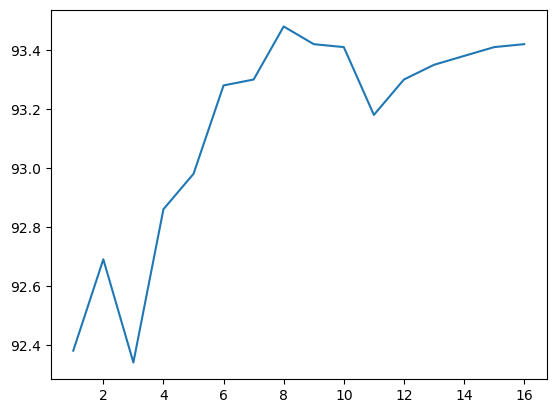

In [20]:
plt.plot(range(1, 17), test_acc_s)

Is ensemble always better?

In [36]:
for i in range(2, 25):
    acc = validate_snn_ensemble([model_s[j] for j in sorted_indices[:i]], test_loader, n_steps, device)
    print(f'{i} models, acc: {acc}')

Accuracy of the network on the test images: 93.720000
2 models, acc: 93.72
Accuracy of the network on the test images: 94.040000
3 models, acc: 94.04
Accuracy of the network on the test images: 94.200000
4 models, acc: 94.2
Accuracy of the network on the test images: 94.200000
5 models, acc: 94.2
Accuracy of the network on the test images: 94.210000
6 models, acc: 94.21
Accuracy of the network on the test images: 94.260000
7 models, acc: 94.26
Accuracy of the network on the test images: 94.230000
8 models, acc: 94.23
Accuracy of the network on the test images: 94.170000
9 models, acc: 94.17
Accuracy of the network on the test images: 94.260000
10 models, acc: 94.26
Accuracy of the network on the test images: 94.230000
11 models, acc: 94.23
Accuracy of the network on the test images: 94.310000
12 models, acc: 94.31
Accuracy of the network on the test images: 94.340000
13 models, acc: 94.34
Accuracy of the network on the test images: 94.410000
14 models, acc: 94.41
Accuracy of the networ

test spawning setting (epoch 3)

finging: using spawning in this setting will lead to decrease in ensemble performance, though merging seems to slightly improves (?). Also, PFM becomes less effective.

So perhaps it's not recommended to use spawning in this setting

In [17]:
model_merge_1 = deepcopy(model_s[0])
model_merge_2 = deepcopy(model_s[1])
model_merge_3 = deepcopy(model_s[2])

sd_child_1 = torch.load('cifar10_vgg16_3_updated_snn1_1.pth', weights_only=True)
sd_child_2 = torch.load('cifar10_vgg16_3_updated_snn1_1_v2.pth', weights_only=True)
sd_child_3 = torch.load('cifar10_vgg16_3_updated_snn1_1_v3.pth', weights_only=True)

model_merge_1.load_state_dict(sd_child_1)
model_merge_2.load_state_dict(sd_child_2)
model_merge_3.load_state_dict(sd_child_3)

<All keys matched successfully>

In [18]:
model_merge_1, model_merge_2, model_merge_3 = model_merge_1.to(device), model_merge_2.to(device), model_merge_3.to(device)

validate_snn(model_merge_1, test_loader, n_steps, device)
validate_snn(model_merge_2, test_loader, n_steps, device)
validate_snn(model_merge_3, test_loader, n_steps, device)

Accuracy of the network on the test images: 92.260000
Accuracy of the network on the test images: 92.370000
Accuracy of the network on the test images: 92.370000


92.37

In [21]:
validate_snn_ensemble([model_merge_1, model_merge_2, model_merge_3], test_loader, n_steps, device)

Accuracy of the network on the test images: 93.690000


93.69

In [35]:
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts([sd_child_2, sd_child_3], [1/2]*2, use_slerp=False)
model_mid.load_state_dict(sd_mid)
model_mid = model_mid.to(device)
# validate_snn(model_mid, test_loader, n_steps, device)
reset_bn_stats(model_mid, device, train_loader, n_steps, layerwise=False, ann=False)
validate_snn(model_mid, test_loader, n_steps, device)

Accuracy of the network on the test images: 92.300000


92.3

In [30]:
model_merge_s = [model_merge_2, model_merge_3]
for model in model_merge_s:
    model.to(device)
    model.eval()
num_models = len(model_merge_s)
model_mid = deepcopy(model_s[0])
sd_mid = interpolate_multi_state_dicts([model.state_dict() for model in model_merge_s], [1/num_models]*num_models, use_slerp=False)
model_mid.load_state_dict(sd_mid)
model_mid.to(device).eval()

validate_snn(model_mid, test_loader, n_steps, device) # direct merge

test_acc_s = []
for L in range(1, 17):
    total = 0
    correct = 0
    for data, target in test_loader:
        data = add_dimension(data, n_steps)
        data, target = data.to(device), target.to(device)
        outputs = PFM_outputs(model_merge_s, model_mid, data, L, n_steps)
        total += target.size(0)
        correct += (outputs.argmax(1) == target).sum().item()

    print('Accuracy of the network on the test images: %f' % (100 * correct / total), f", L={L}")
    acc = 100 * correct / total
    test_acc_s.append(acc)

Accuracy of the network on the test images: 92.350000
Accuracy of the network on the test images: 92.500000 , L=1
Accuracy of the network on the test images: 92.360000 , L=2
Accuracy of the network on the test images: 92.610000 , L=3
Accuracy of the network on the test images: 92.720000 , L=4
Accuracy of the network on the test images: 92.890000 , L=5
Accuracy of the network on the test images: 92.990000 , L=6
Accuracy of the network on the test images: 93.220000 , L=7
Accuracy of the network on the test images: 93.200000 , L=8
Accuracy of the network on the test images: 93.250000 , L=9
Accuracy of the network on the test images: 93.260000 , L=10
Accuracy of the network on the test images: 93.280000 , L=11
Accuracy of the network on the test images: 93.310000 , L=12
Accuracy of the network on the test images: 93.210000 , L=13
Accuracy of the network on the test images: 93.330000 , L=14
Accuracy of the network on the test images: 93.300000 , L=15
Accuracy of the network on the test imag